In [1]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

CPU times: total: 641 ms
Wall time: 973 ms


In [2]:
%%time
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = [
    '2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 
    'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [
    3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 
    2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]
Homo_eV = [
    -5.1876, -5.4716, -5.5685, -5.5091, -5.6217, -5.6347, -5.1710, -6.6011, 
    -5.6247, -5.5399, -5.3205, -5.0740, -6.2168, -4.9084, -5.7404, -5.7209, 
    -5.3831, -5.8692, -5.4390]
Lumo_eV = [
    -2.1106, -2.3994, -2.3092, -2.8837, -2.6840, -2.6890, -2.3595, -3.3695, 
    -2.8896, -2.6622, -2.6347, -2.3040, -3.2160, -2.2062, -2.7706, -2.8307, 
    -2.5237, -2.7325, -2.9139]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo (eV)': Homo_eV,
    'Lumo (eV)': Lumo_eV,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= 0]
opv_df_filtered.reset_index(drop=True, inplace=True)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df_filtered.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.50)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'LUMO_calc', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (26689, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (25767, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (25918, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (26689, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (25682, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (25631, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (25647, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (25682, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (25631, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (25818, 4)
Generated dataframe for segm

In [ ]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()
    
    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (26689, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (25767, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (25918, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (26689, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (25682, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (25631, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (25647, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (25682, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (25631, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (25818, 20

MemoryError: Unable to allocate 402. MiB for an array with shape (25700, 2048) and data type object

In [4]:
import pandas as pd
from rdkit import Chem
from functools import reduce

# Backbone SMILES with placeholders for R1 and R2
curcumin_backbone = "F[B-]1(F)OC(/C=C/[R1])=CC(/C=C/[R2])=[O+]1"

# List of side groups with [R] placeholder
side_groups = {
    "sidegroup01": "CC(C)C[R]",
    "sidegroup02": "CCCC[R]",
    "sidegroup03": "[R]c2ccc(C#Cc1ccccc1)cc2",
    "sidegroup04": "COc1ccc([R])cc1",
    "sidegroup05": "COc1ccccc1[R]",
    "sidegroup06": "COc1ccc([R])c(OC)c1",
    "sidegroup07": "COc1cc(OC)c([R])c(OC)c1",
    "sidegroup08": "COc1ccc(OC)c([R])c1",
    "sidegroup09": "COc1cc([R])cc(OC)c1",
    "sidegroup10": "COc1ccc([R])cc1OC",
    "sidegroup11": "CCCCCCCCOc1ccc([R])cc1OC",
    "sidegroup12": "CN(C)c1ccc([R])cc1",
    "sidegroup13": "CCCCN(CCCC)c1ccc([R])cc1",
    "sidegroup14": "CCCOc1cc(N(CC)CC)ccc1[R]",
    "sidegroup15": "N#Cc1ccc([R])cc1",
    "sidegroup16": "[R]c1ccccc1",
    "sidegroup17": "Cc1ccc([R])cc1",
    "sidegroup18": "Brc1ccc([R])cc1",
    "sidegroup19": "CSc1ccc([R])cc1",
    "sidegroup20": "COC(=O)c1ccc([R])cc1",
    "sidegroup21": "CCCCN(CCCC)c1ccc([R])s1",
    "sidegroup22": "CN2/C(=C/[R])C(C)(C)c1ccccc12",
    "sidegroup23": "Cc2ccc(c1ccc([R])s1)s2",
    "sidegroup24": "CCCCCC(CC)c2ccc(c1ccc([R])s1)s2",
    "sidegroup25": "CCCCCCCCc2ccc(c1ccc([R])s1)s2",
    "sidegroup26": "COc1ccc([R])c2ccccc12",
    "sidegroup27": "CN(C)c1ccc([R])c2ccccc12",
    "sidegroup28": "COc2ccc1cc([R])ccc1c2",
    "sidegroup29": "[R]c2c1ccccc1cc3ccccc23",
    "sidegroup30": "Cn3c1ccccc1c2cc([R])ccc23",
    "sidegroup31": "[R]c3ccc(N(c1ccccc1)c2ccccc2)s3",
    "sidegroup32": "[R]c4ccc(n3c1ccccc1c2ccccc23)cc4",
    "sidegroup33": "[R]c3ccc(N(c1ccccc1)c2ccccc2)cc3",
    "sidegroup34": "CCCCCCCCOc3ccc(N(c1ccccc1)c2ccc([R])cc2)cc3",
    "sidegroup35": "[R]c1ccc2ccc3cccc4ccc1c2c34"
}

# Replace placeholders in the backbone
curcumin_backbone = curcumin_backbone.replace("[R1]", "*").replace("[R2]", "*")

# Function to find atom indices with wildcard ('*')
def get_wildcard_indices(mol):
    return [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == "*"]

# Function to clean up double slashes in SMILES
def clean_smiles(smiles):
    return smiles.replace("//", "/")

# Prepare DataFrame to store results
results = []

# Loop over all possible combinations of side groups
for sg1_name, sg1_smiles in side_groups.items():
    for sg2_name, sg2_smiles in side_groups.items():
        # Replace placeholders in side group SMILES with "*"
        sg1_smiles = sg1_smiles.replace("[R]", "*")
        sg2_smiles = sg2_smiles.replace("[R]", "*")

        # Generate RDKit molecule objects
        smiles_list = [curcumin_backbone, sg1_smiles, sg2_smiles]
        mols_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

        # Retrieve '*' indices for the backbone and side groups
        backbone_star_indices = get_wildcard_indices(mols_list[0])[:2]  # First two indices in the backbone
        side1_star_index = get_wildcard_indices(mols_list[1])[0]  # Index in the first side group
        side2_star_index = get_wildcard_indices(mols_list[2])[0]  # Index in the second side group

        # Create an editable molecule by combining the backbone and side groups
        combo = Chem.EditableMol(reduce(Chem.CombineMols, mols_list))

        # Add bonds between backbone and side groups dynamically based on wildcard positions
        combo.AddBond(backbone_star_indices[0], side1_star_index + mols_list[0].GetNumAtoms(), order=Chem.rdchem.BondType.SINGLE)
        combo.AddBond(backbone_star_indices[1], side2_star_index + mols_list[0].GetNumAtoms() + mols_list[1].GetNumAtoms(), order=Chem.rdchem.BondType.SINGLE)

        # Convert the combined molecule to SMILES
        combo_smiles = Chem.MolToSmiles(combo.GetMol())

        # Optionally replace '*' markers with empty space for SMILES cleanup
        combo_smiles = combo_smiles.replace('*', '')

        # Clean up double slashes in SMILES
        combo_smiles = clean_smiles(combo_smiles)

        # Append the result to the DataFrame
        results.append({
            "Side Group 1": sg1_name,
            "Side Group 1 SMILES": sg1_smiles,
            "Side Group 2": sg2_name,
            "Side Group 2 SMILES": sg2_smiles,
            "Combined SMILES": combo_smiles
        })

# Create the DataFrame
Premutated_Mol_df = pd.DataFrame(results)
Premutated_Mol_df

from rdkit.Chem import AllChem

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

Premutated_Mol_df['Morgan_Fingerprints'] = Premutated_Mol_df['Combined SMILES'].apply(generate_morgan_fingerprint_safe)
Premutated_Mol_df = Premutated_Mol_df[Premutated_Mol_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_Premutated_Mol_df = pd.DataFrame(Premutated_Mol_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

Premutated_Mol_df_mf = pd.concat([Premutated_Mol_df.drop(columns=['Morgan_Fingerprints']), morgan_Premutated_Mol_df], axis=1)
Premutated_Mol_df_mf

,Side Group 1,Side Group 1 SMILES,Side Group 2,Side Group 2 SMILES,Combined SMILES,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,sidegroup01,CC(C)C*,sidegroup01,CC(C)C*,CC(C)C/C=C/C1=CC(/C=C/CC(C)C)=[O+][B-](F)(F)O1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sidegroup01,CC(C)C*,sidegroup02,CCCC*,CCCC/C=C/C1=[O+][B-](F)(F)OC(/C=C/CC(C)C)=C1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sidegroup01,CC(C)C*,sidegroup03,*c2ccc(C#Cc1ccccc1)cc2,CC(C)C/C=C/C1=CC(/C=C/c2ccc(C#Cc3ccccc3)cc2)=[...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,sidegroup01,CC(C)C*,sidegroup04,COc1ccc(*)cc1,COc1ccc(/C=C/C2=[O+][B-](F)(F)OC(/C=C/CC(C)C)=...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sidegroup01,CC(C)C*,sidegroup05,COc1ccccc1*,COc1ccccc1/C=C/C1=[O+][B-](F)(F)OC(/C=C/CC(C)C...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup31,*c3ccc(N(c1ccccc1)c2ccccc2)s3,F[B-]1(F)OC(/C=C/c2ccc3ccc4cccc5ccc2c3c45)=CC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1221,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup32,*c4ccc(n3c1ccccc1c2ccccc23)cc4,F[B-]1(F)OC(/C=C/c2ccc3ccc4cccc5ccc2c3c45)=CC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1222,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup33,*c3ccc(N(c1ccccc1)c2ccccc2)cc3,F[B-]1(F)OC(/C=C/c2ccc3ccc4cccc5ccc2c3c45)=CC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1223,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup34,CCCCCCCCOc3ccc(N(c1ccccc1)c2ccc(*)cc2)cc3,CCCCCCCCOc1ccc(N(c2ccccc2)c2ccc(/C=C/C3=[O+][B...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
seg02_atom_pair_cosine = similarity_dfs['seg02_atom_pair_cosine']
seg02_atom_pair_cosine.head()

,smiles,mol,LUMO_calc,similarity_seg02_atom_pair_cosine
2,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000291B38...,-5.349517,0.611430
6,O=C(O)c1onc(-c2c3c(c(-c4noc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000291B51...,-5.059577,0.640513
17,Cn1c(C2=CC(=C(C#N)C#N)C=C(C(=O)C3=CC(=C(C#N)C#...,<rdkit.Chem.rdchem.Mol object at 0x00000291B38...,-4.849178,0.583545
22,O=C(O)c1csc(-c2c3c(c(-c4scc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000291B55...,-4.816415,0.663388
23,Cn1c(=O)c2c(C3=C(C#N)C(=C(C#N)C#N)SC3=O)c3c4cc...,<rdkit.Chem.rdchem.Mol object at 0x00000291B38...,-4.804577,0.578315


In [6]:
Premutated_Mol_df_mf_X = Premutated_Mol_df_mf.iloc[:, 5:]
Premutated_Mol_df_mf_X.head()

,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,morgan_7,morgan_8,morgan_9,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time

import pandas as pd
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# List of best models and their corresponding DataFrame keys
best_models_all_segments = [
    "seg02_atom_pair_cosine"
]

# Loop over each model
for model_name in best_models_all_segments:
    print("___________________________________________________________________")
    print(f"Processing {model_name}")
    
    # Load the respective DataFrame
    df = processed_similarity_dfs[model_name]
    X = df.iloc[:, 4:] 
    y = df['LUMO_calc'] 

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model = SVR(C=10, epsilon=0.01, kernel='rbf')
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print(f"Finished training {model_name}")
    y_pred_default = model.predict(X_test)
    r2_model = model.score(X_test, y_test)
    rmse_model = np.sqrt(mean_squared_error(y_test, y_pred_default))
    mae_model = np.mean(np.abs(y_test - y_pred_default))
    
    print(f"Model {model_name}")
    print(f"R2 Value: {r2_model:.5f}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    print("___________________________________________________________________")

print("Predicting LUMO values for the premutated molecules...")
Premutated_Mol_df_mf_X = Premutated_Mol_df_mf.iloc[:, 5:]
Premutated_Mol_df_mf['Lumo (eV) Pred'] = model.predict(Premutated_Mol_df_mf_X)
Premutated_Mol_df_mf = Premutated_Mol_df_mf.sort_values(by='Lumo (eV) Pred', ascending=False).reset_index(drop=True)
Premutated_Mol_df_mf

___________________________________________________________________
Processing seg02_atom_pair_cosine
Training seg02_atom_pair_cosine...


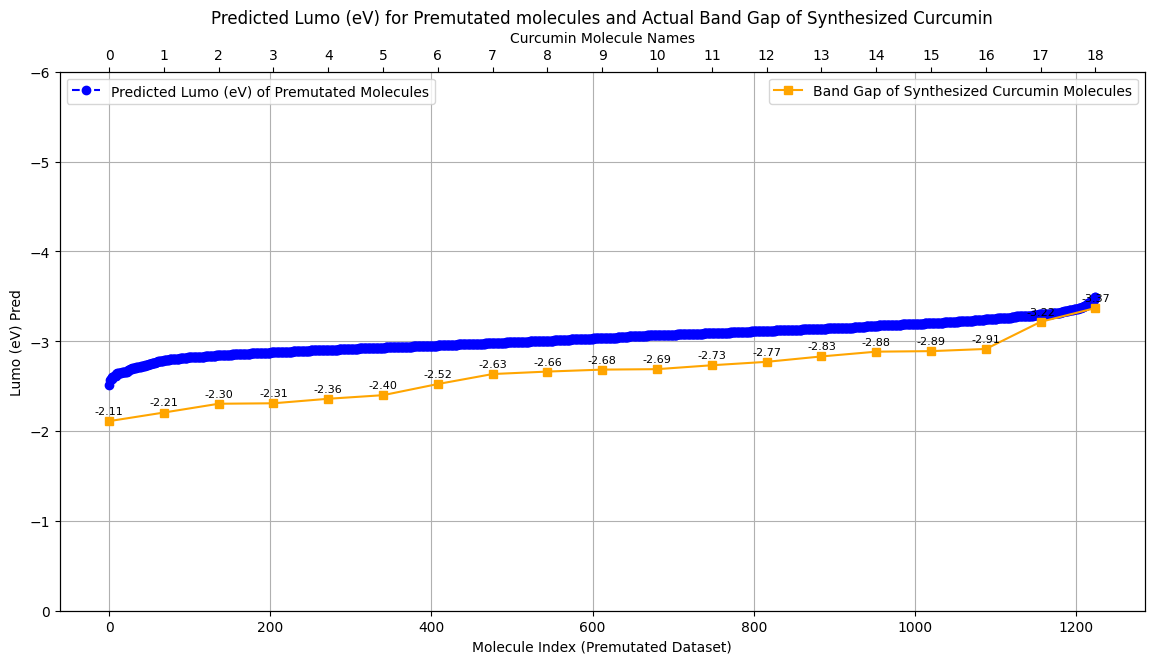

In [ ]:
import matplotlib.pyplot as plt

# Create the main figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

curcumin_df_mf = curcumin_df_mf.sort_values(by='Lumo (eV)', ascending=False).reset_index(drop=True)

# Plot `Premutated_Mol_df_mf` Lumo (eV) Prediction on the primary axis
ax1.plot(Premutated_Mol_df_mf['Lumo (eV) Pred'], label='Predicted Lumo (eV) of Premutated Molecules', marker='o', linestyle='--', color='blue')
ax1.set_xlabel('Molecule Index (Premutated Dataset)')
ax1.set_ylabel('Lumo (eV) Pred')
ax1.set_ylim(0.0, -6)
ax1.legend(loc='upper left')
ax1.grid(True)

# Secondary x-axis for displaying the entire `curcumin_df_mf` dataset
ax2 = ax1.twiny()
ax2.plot(range(len(curcumin_df_mf)), curcumin_df_mf['Lumo (eV)'], label='Band Gap of Synthesized Curcumin Molecules', marker='s', color='orange')
ax2.set_xticks(range(len(curcumin_df_mf)))  # Set x-ticks to cover all curcumin molecules
ax2.set_xlabel('Curcumin Molecule Names')
ax2.legend(loc='upper right')

for i, value in enumerate(curcumin_df_mf['Lumo (eV)']):
    ax2.annotate(f"{value:.2f}", (i, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

# Set the title
plt.title('Predicted Lumo (eV) for Premutated molecules and Actual Band Gap of Synthesized Curcumin')
plt.show()

In [ ]:
curcumin_df_mf.head(2)

,Molecule,Molecular Weight,LogP,Homo (eV),Lumo (eV),Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,...,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047,Lumo (eV) Pred,absolute_variance
0,2-ADMeO3,532.345,5.0293,-5.1876,-2.1106,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,...,0,0,0,0,0,0,0,0,-3.188983,1.078383
1,AD-48,542.479,7.8955,-4.9084,-2.2062,2.702,CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C...,0,0,0,...,0,0,0,0,0,0,0,0,-2.534035,0.327835


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Prediction --> model MAE: 0.45362 & RMSE: 0.52554
Prediction --> model R2 Score: -932.1129
___________________________________________________________________


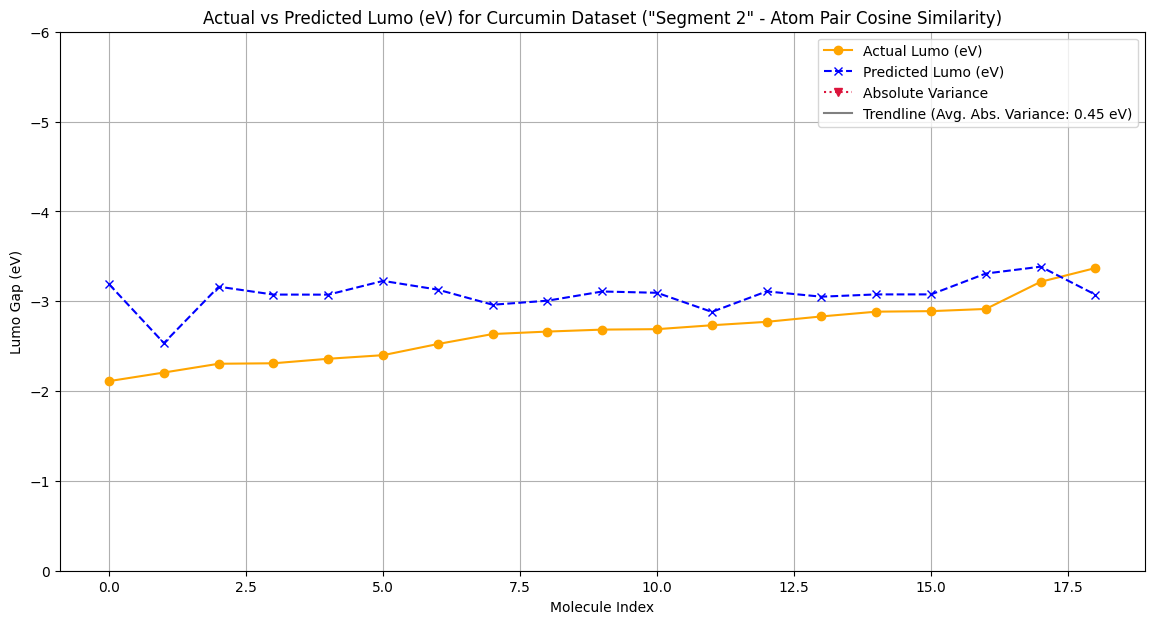

In [19]:
# Predict on the curcumin dataset using the same selected features
curcumin_X = curcumin_df_mf.iloc[:, 7:]
curcumin_df_mf['Lumo (eV) Pred'] = model.predict(curcumin_X)

curcumin_df_mf = curcumin_df_mf.sort_values(by='Lumo (eV)', ascending=False).reset_index(drop=True)

mae_predict = mean_absolute_error(curcumin_df_mf['Lumo (eV)'], curcumin_df_mf['Lumo (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf['Lumo (eV)'], curcumin_df_mf['Lumo (eV) Pred'], squared=False)
r2_predict = model.score(curcumin_X, curcumin_df_mf['Homo-Lumo Gap (eV)'])
print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
print("___________________________________________________________________")

# Calculate absolute variance and average variance
curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Lumo (eV)'] - curcumin_df_mf['Lumo (eV) Pred']).abs()
average_variance = curcumin_df_mf['absolute_variance'].mean()

plt.figure(figsize=(14, 7))
plt.plot(curcumin_df_mf['Lumo (eV)'], label='Actual Lumo (eV)', marker='o', color='orange')
plt.plot(curcumin_df_mf['Lumo (eV) Pred'], label='Predicted Lumo (eV)', marker='x', linestyle='--', color='blue')

plt.plot(curcumin_df_mf['absolute_variance'], label='Absolute Variance', marker='v', linestyle=':', color='crimson')

x_vals = np.arange(len(curcumin_df_mf))
trendline = np.polyval(np.polyfit(x_vals, curcumin_df_mf['absolute_variance'], 1), x_vals)
plt.plot(trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

plt.xlabel('Molecule Index')
plt.ylabel('Lumo Gap (eV)')
plt.title(f'Actual vs Predicted Lumo (eV) for Curcumin Dataset ("Segment 2" - Atom Pair Cosine Similarity)')
plt.ylim(0, -6)
plt.legend()
plt.grid(True)

plt.show()